In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
from datetime import date
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

%run ../global_variables.py ./
%run ../global_functions.py ./

We load the climate colormap from the Koppen-Geiger classification. Color maps are either defined for all 31 zones (`approximate=False`) or for 5 largest zones (`approximate=True`).

In [3]:
approximate=True
if approximate:
    cmap_climate=ListedColormap(np.loadtxt("../datasets/other/koppen_geiger_color_array_approx.csv"))
else:
    cmap_climate=ListedColormap(np.loadtxt("../datasets/other/koppen_geiger_color_array.csv"))

<div class="alert alert-block alert-info">
<b>How to use this notebook:</b> Each part can be ran independently.
</div>

<div class="alert alert-block alert-info"> 
    <b> Part 1</b> Compute step by step the basin average for one hydrological variable (P, ET, R, PET, TWS) over the basin you chose. Shows the spatial grid use for averaging and therefore holes (such as lakes) are visible, or missing values for some months in GRACE data are shown before interpolation. These steps are computed in the notebook `Save basins data` to increase speed.
    </div>

<div class="alert alert-block alert-info"> 
    <b> Part 2</b> For a given basin and a combination of datasets, compute the water budget from basin timeseries.
    </div>

<div class="alert alert-block alert-info"> 
    <b> Part 3</b> Compare basin timeseries for a selection of datasets.
    </div>

<div class="alert alert-block alert-info"> 
    <b> Part 4</b> Plot epochs when each dataset is available
    </div>

# 1. Hydrological variable in a basin

## 1.1. Load data

Load the spatial grid where variables are available (`spatial_grid`).

`hydro_grid` is a DataFrame with each row representing a cell grid and each column is a month

`time_hydro` is the set of months when the current variable is known

- For precipitations (`'P'`) choose among : `'CPC'`, `'CRU'`, `'ERA5_Land'`, `'GPCC'`, `'GPCP'`, `'GPM'`, `'MERRA2'`, `'MSWEP'`, `'TRMM'`

- For evapotranspiration (`'ET'`) choose among : `'ERA5_Land'`,`'GLEAM'`, `'GLDAS20_NOAH36'`, `'GLDAS20_CLSM25'`, `'GLDAS20_VIC412'`, `'GLDAS21_NOAH36'`, `'GLDAS21_CLSM25'`, `'GLDAS21_VIC412'`, `'MERRA2'`, `'MOD16'`, `'SSEBop'`

- For runoff (`'R'`) choose among `'ERA5_Land'`, `'GLDAS20_NOAH36'`, `'GLDAS20_CLSM25'`, `'GLDAS20_VIC412'`, `'GLDAS21_NOAH36'`, `'GLDAS21_CLSM25'`, `'GLDAS21_VIC412'`, `'GRUN'`, `'MERRA2'`

- For water storage (`'TWS'`) choose among `'GRACE_JPL_mascons'`, `'GRACE_CSR_mascons'`, `'GRACE_CSR_grid'`, `'GRACE_ITSG_grid'`

- For potential evapotranspiration (`'PET'`) choose among `'SSEBop'`, `'CRU'`, `'GLEAM'`

In [3]:
hydro_var_name='P'
data='GPCP'

(spatial_grid,hydro_grid,time_hydro)=load_hydro_data(hydro_var_name,data,
                            fill_value=dict_fill_value[data],version=version_data[data])

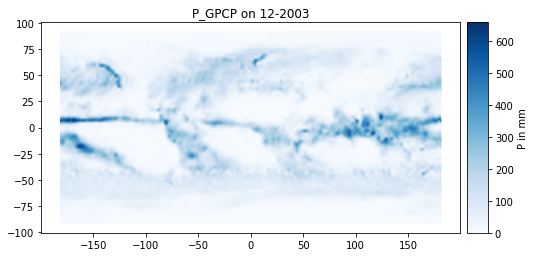

In [4]:
month='12'
year='2003'

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

norm,cmap=define_cmap(hydro_var_name,hydro_grid,year,month)
fig, ax = plt.subplots(figsize=(8,5))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

world.plot(ax=ax, color='white', edgecolor='black')
hydro_grid.plot(ax=ax,marker='.',column='{} {}-{}-15'.format(hydro_var_name,year,month),
             legend=True,legend_kwds={'label': "{} in mm".format(hydro_var_name)},cax=cax,
            cmap=cmap,norm=norm)

ax.set_title('{}_{} on {}-{}'.format(hydro_var_name,data,month,year))
#plt.savefig('../plots/hydrology/{}_{}_world_{}_{}.png'.format(hydro_var_name,data,month,year))
plt.show()

Load basins data : 
- `RASTAREA` is the basin area in km^2
- `MAIN_CLIMATE` is the Koppen-Geiger climate zone covering the largest part of the basin
- `CLIMATE_AREA_%` is the area percentage covered by the main climate
- `COLOR` is the official color associated to the climate area
- `NB_RUNOFF` is the number of stations inside the basin in operation at least 1 year between 2003 and 2017

In [5]:
basins=load_basins_data(approximate)
basins

,RASTAREA,LATITUDE,MAIN_CLIMATE,CLIMATE_AREA_%,COLOR,NB_RUNOFF,geometry
NAME,,,,,,,
KHATANGA,265580.70,69.00,D,91.129714,#ff6eff,0,"POLYGON ((107.98472 70.60880, 107.99635 70.602..."
COLVILLE RIVER,54793.19,69.00,E,70.030254,#6395ff,1,"POLYGON ((-151.63553 68.05583, -151.56200 68.0..."
ODER RIVER,107297.80,51.75,C,94.763680,#007800,53,"POLYGON ((17.77023 53.33484, 17.75817 53.27876..."
ELBE RIVER,134036.70,51.00,C,96.768446,#007800,69,"POLYGON ((15.71059 50.73571, 15.80232 50.74939..."
TRENT,5591.48,53.00,C,100.000000,#007800,8,"POLYGON ((-1.04140 52.50355, -1.07763 52.46482..."
...,...,...,...,...,...,...,...
URAL,194095.00,52.00,D,97.769008,#ff6eff,0,"POLYGON ((59.45863 54.73093, 59.45405 54.71379..."
WISLA,186147.40,51.50,D,58.274787,#ff6eff,36,"POLYGON ((23.27742 53.82209, 23.28833 53.78495..."
DON,378180.40,50.25,D,100.000000,#ff6eff,1,"POLYGON ((44.20445 47.83303, 44.16977 47.78534..."


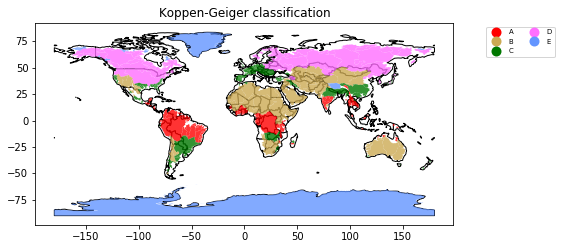

In [6]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(8,5))
ax.set_aspect('equal')
world.plot(ax=ax, color='white', edgecolor='black')
basins.plot(ax=ax, column='MAIN_CLIMATE', categorical=True,
             legend=True, cmap=cmap_climate,
                 legend_kwds={'bbox_to_anchor':(1.25,1.0),'ncol':2,'fontsize':'x-small'})
ax.set(title='Koppen-Geiger classification')
fig.tight_layout()
plt.show()

## 1.2. Basin selection

Choose the basin you are interested in and plot its geography

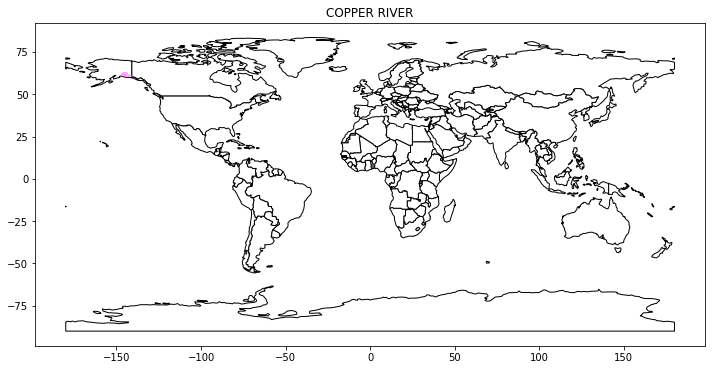

In [11]:
basin_name='COPPER RIVER'

fig, ax = plt.subplots(figsize=(12,10))
ax.set_aspect('equal')
world.plot(ax=ax, color='white', edgecolor='black')
basins.loc[[basin_name],'geometry'].plot(ax=ax, color=basins.loc[basin_name,'COLOR'],alpha=0.7)
plt.title(basin_name)
plt.show()

To find the grid coordinates loacted inside a given basin, we rely on R-trees (__[reference](https://automating-gis-processes.github.io/site/notebooks/L3/spatial_index.html)__) in the function `find_coordinates_inside_basin`. The method is the following : 

1. we compare the bounds of the Polygon into the spatial index of the Points. This gives us point candidates that are likely to be within the Polygon (at this stage based on the MBR of the points that is stored inside the R-tree). 

1. we go through the candidate points and make a normal spatial intersection query that gives us the accurate results

In [12]:
my_basin=basins.loc[[basin_name],'geometry']
final_selection=find_coordinates_inside_basin(my_basin,spatial_grid,basins)

In [13]:
hydro_basin=hydro_grid.loc[final_selection.index]

## 1.3. Missing values over the basin

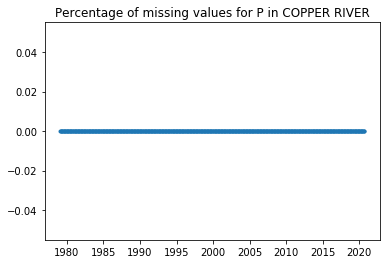

In [14]:
nb_missing_values=hydro_basin.loc[:,['{} {}'.format(hydro_var_name,d.date()) for d in time_hydro]].isna().sum()
perc_missing_values=100*nb_missing_values/final_selection.shape[0]
plt.figure()
plt.plot(time_hydro,perc_missing_values,'.')
plt.title("Percentage of missing values for {} in {}".format(hydro_var_name,basin_name))
plt.show()

If needed, we reconstruct temporal missing values with interpolation (cubic by default) and spatial missing values with at least two neighbours

In [13]:
hydro_basin,filling=my_fillna(hydro_basin,hydro_var_name,time_hydro,data,version=version_data[data])
filling

True

Plot all grid points inside the basin

c:\users\fafal\miniconda3\lib\site-packages\geopandas\plotting.py:335: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


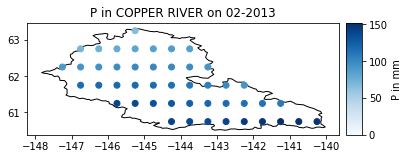

In [15]:
year=2013
month='02'

norm,cmap=define_cmap(hydro_var_name,hydro_basin,year,month)

fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

my_basin.plot(ax=ax, color='white', edgecolor='black')
hydro_basin.plot(ax=ax,column='{} {}-{}-15'.format(hydro_var_name,year,month),
             legend=True,legend_kwds={'label': "{} in mm".format(hydro_var_name)},cax=cax,
                 missing_kwds={"color": "red",},
            cmap=cmap,norm=norm)
ax.set_title('{} in {} on {}-{}'.format(hydro_var_name,basin_name,month,year))
plt.show()

## 1.4. Spatial averaging

Compute the weighted average for all grid points inside the basin, taking into account the Earth curvature.

In [16]:
hydro_mean_basin, hydro_mean_basin_filter=hydrological_variables_basin_filtered(hydro_basin,hydro_var_name,
                                                                time_hydro,data,version=version_data[data])

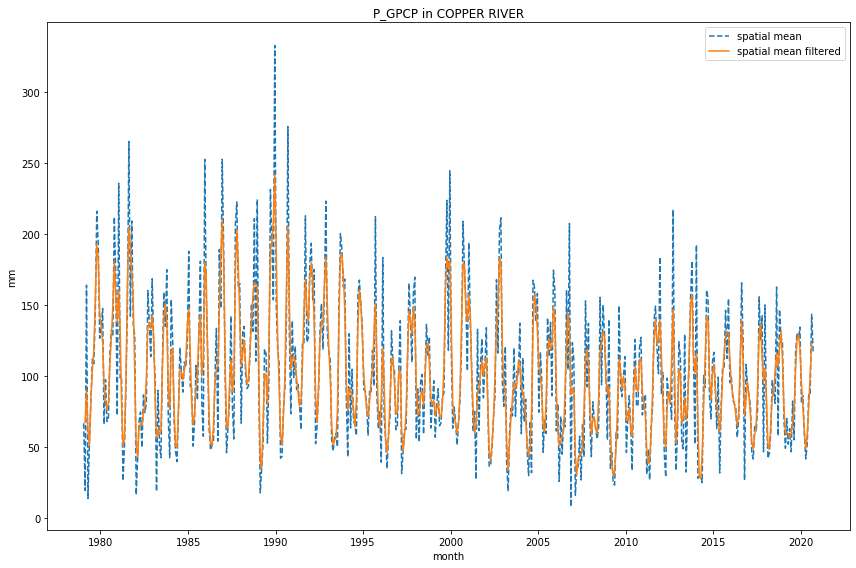

In [19]:
plt.figure(figsize=(12,8))
if hydro_var_name=='TWS': # filtered and unfiltered variables are the same for water storage CHANGES
    plt.plot(time_hydro,hydro_mean_basin,label='spatial mean')
else:
    plt.plot(time_hydro,hydro_mean_basin,'--',label='spatial mean')
    plt.plot(time_hydro[1:-1],hydro_mean_basin_filter,label='spatial mean filtered')
plt.legend()
plt.xlabel("month")
plt.ylabel("mm")
plt.title("{}_{} in {}".format(hydro_var_name,data,basin_name))
plt.tight_layout()
plt.show()

# 2. Water budget

In [3]:
basins=load_basins_data(approximate)

Choose a basin and a set of datasets to plot the water budget in this basin.

In [4]:
basin_name='COPPER RIVER'

data_P='GPCP'
data_ET='GLDAS21_CLSM25'
data_R='GRUN'
data_TWS='GRACE_JPL_mascons'

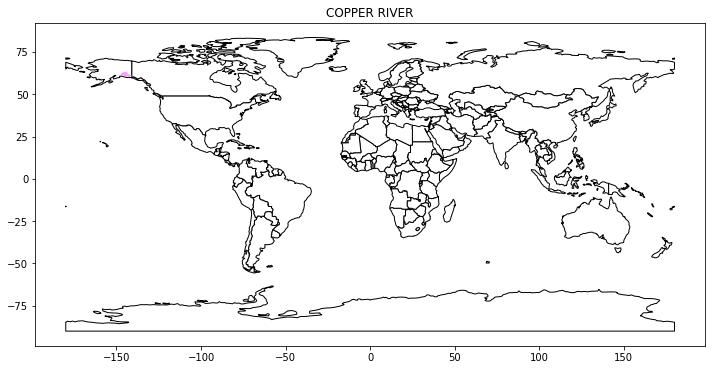

In [6]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(12,8))
ax.set_aspect('equal')
world.plot(ax=ax, color='white', edgecolor='black')
basins.loc[[basin_name],'geometry'].plot(ax=ax, color=basins.loc[basin_name,'COLOR'],alpha=0.7)
plt.title(basin_name)
plt.show()

Load timeseries of hydrological variables aggregated at the basin scale and filtered to match water storage derivative.

In [7]:
TWS_month=pd.read_csv('../results/hydrology/TWS_{}_monthly_filtered.csv'.format(data_TWS),index_col=[0])
time_TWS=pd.to_datetime(TWS_month.columns.str[4+len(data_TWS):])

P_month=pd.read_csv('../results/hydrology/P_{}_monthly_filtered.csv'.format(data_P),index_col=[0])
time_P=pd.to_datetime(P_month.columns.str[2+len(data_P):])

ET_month=pd.read_csv('../results/hydrology/ET_{}_monthly_filtered.csv'.format(data_ET),index_col=[0])
time_ET=pd.to_datetime(ET_month.columns.str[3+len(data_ET):])

R_month=pd.read_csv('../results/hydrology/R_{}_monthly_filtered.csv'.format(data_R),index_col=[0])
time_R=pd.to_datetime(R_month.columns.str[2+len(data_R):]) 

time_idx=pd.date_range(max(time_P.min(),time_ET.min(),time_R.min(),time_TWS.min()),
       min(time_P.max(),time_ET.max(),time_R.max(),time_TWS.max()),
      freq='SM')[::2]

Select timeseries over the basin of interest, check that there is no hole over the basin (for example a lake not recovered by the function `my_fillna` above) and compute the net accumulation.

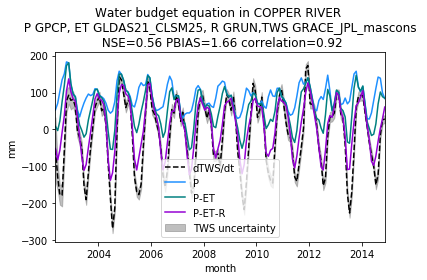

In [10]:
P_filter=P_month.loc[basin_name,['P_{} {}'.format(data_P,d.date()) for d in time_idx]]
ET_filter=ET_month.loc[basin_name,['ET_{} {}'.format(data_ET,d.date()) for d in time_idx]]
R_filter=R_month.loc[basin_name,['R_{} {}'.format(data_R,d.date()) for d in time_idx]]
TWSC_filter=TWS_month.loc[basin_name,['TWS_{} {}'.format(data_TWS,d.date()) for d in time_idx]]

fillingP=(np.sum(np.isnan(P_filter))==0)
fillingET=(np.sum(np.isnan(ET_filter))==0)
fillingR=(np.sum(np.isnan(R_filter))==0)
fillingTWS=(np.sum(np.isnan(TWSC_filter))==0)

if fillingP&fillingET&fillingR&fillingTWS: # if this basin is entirely covered by all datasets, proceed, otherwise the loop ends
    A_filter=pd.Series(P_filter.values-ET_filter.values-R_filter.values,index=time_idx)
    plot_water_budget_details(TWSC_filter,P_filter,ET_filter,R_filter,time_idx,basin_name,data_P,data_ET,data_R,data_TWS)
else:
    print('This basin is not entirely covered')

# 3. Compare datasets for a given hydrological variable

Choose a basin, one hydrological variable and a set of datasets.

- For precipitations (`'P'`) choose among : `'CPC'`, `'CRU'`, `'ERA5_Land'`, `'GPCC'`, `'GPCP'`, `'GPM'`, `'MERRA2'`, `'MSWEP'`, `'TRMM'`

- For evapotranspiration (`'ET'`) choose among : `'ERA5_Land'`,`'GLEAM'`, `'GLDAS20_NOAH36'`, `'GLDAS20_CLSM25'`, `'GLDAS20_VIC412'`, `'GLDAS21_NOAH36'`, `'GLDAS21_CLSM25'`, `'GLDAS21_VIC412'`, `'MERRA2'`, `'MOD16'`, `'SSEBop'`

- For runoff (`'R'`) choose among `'ERA5_Land'`, `'GLDAS20_NOAH36'`, `'GLDAS20_CLSM25'`, `'GLDAS20_VIC412'`, `'GLDAS21_NOAH36'`, `'GLDAS21_CLSM25'`, `'GLDAS21_VIC412'`, `'GRUN'`, `'MERRA2'`

- For water storage (`'TWS'`) choose among `'GRACE_JPL_mascons'`, `'GRACE_CSR_mascons'`, `'GRACE_CSR_grid'`, `'GRACE_ITSG_grid'`

- For potential evapotranspiration (`'PET'`) choose among `'SSEBop'`, `'CRU'`, `'GLEAM'`

In [3]:
basin_name='COPPER RIVER'

In [17]:
hydro_var_name='ET'
list_data=['ERA5_Land','GLDAS20_CLSM25','SSEBop','GLEAM','MOD16']

In [4]:
hydro_var_name='P'
list_data=['GPCP','GPM','GPCC']

In [43]:
hydro_var_name='R'
list_data=['MERRA2','GRUN','ERA5_Land']

In [20]:
hydro_var_name='TWS'
list_data=['GRACE_JPL_mascons','GRACE_CSR_mascons','GRACE_CSR_grid','GRACE_ITSG']

In [41]:
hydro_var_name='PET'
list_data=['SSEBop','CRU','GLEAM']

Plot the timeseries of the selected datasets. Allows to compare accuracy, trends...

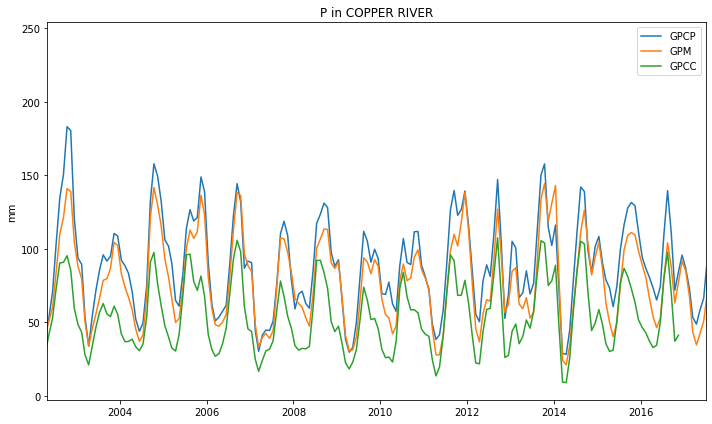

In [5]:
plt.figure(figsize=(10,6))

for data in list_data:
    hydro_month=pd.read_csv('../results/hydrology/{}_{}_monthly_filtered.csv'.format(hydro_var_name,data),
                                                            index_col=[0])
    time_hydro=pd.to_datetime(hydro_month.columns.str[len(hydro_var_name)+1+len(data):])
    plt.plot(time_hydro,hydro_month.loc[basin_name],label=data)
plt.legend()
plt.title("{} in {}".format(hydro_var_name,basin_name))
plt.ylabel("mm")
plt.xlim([date(2002,5,1),date(2017,7,1)])
plt.tight_layout()
plt.show()    

### It's clear that datasets give different timeseries, but how do they differ in terms of mean annual variations? 

Compute the mean value of the hydrological variable per month in a given basin.

In [6]:
def compute_mean_annual_hydro(hydro_month,hydro_var_name,data,basin_name,time_overlap):
    hydro_basin=hydro_month.loc[basin_name,['{}_{} {}'.format(hydro_var_name,data,d.date()) for d in time_overlap[:-1]]].to_frame()
    hydro_basin.index=time_overlap[:-1]
    hydro_basin['month']=hydro_basin.index.month
    hydro_basin_mean=hydro_basin.groupby('month').mean()
    hydro_basin_std=hydro_basin.groupby('month').std()
    # transform to Series
    hydro_basin_mean=pd.Series(hydro_basin_mean.values.flatten(),index=np.arange(1,13),name=basin_name)
    hydro_basin_std=pd.Series(hydro_basin_std.values.flatten(),index=np.arange(1,13),name=basin_name)
    return hydro_basin_mean,hydro_basin_std

In [7]:
min_year=2002
max_year=2016
month_start=5 # data computed from May to April
time_overlap=pd.date_range(start=date(min_year,month_start,1),end=date(max_year,month_start+1,1),freq='SM')[::2]

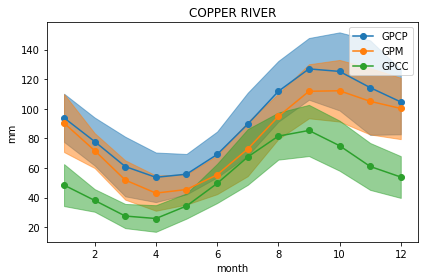

In [8]:
plt.figure()
for i,data in enumerate(list_data):
    hydro_month=pd.read_csv('../results/hydrology/{}_{}_monthly_filtered.csv'.format(hydro_var_name,data),
                                                            index_col=[0])
    hydro_mean,hydro_std=compute_mean_annual_hydro(hydro_month,hydro_var_name,data,basin_name,time_overlap)
    line,=plt.plot(np.arange(1,13),hydro_mean,'-o',label=data)
    plt.fill_between(np.arange(1,13),hydro_mean-hydro_std,hydro_mean+hydro_std,color=line.get_color(),alpha=0.5)
plt.xlabel('month')
plt.ylabel('mm')
plt.title(basin_name)
plt.legend()
plt.tight_layout()
plt.show()

# 4. Datasets availability over time

For each hydrological variable, plot the period where each dataset is known.

In [5]:
list_data_P=['CPC','CRU','ERA5_Land','GPCC','GPCP','GPM','MERRA2','MSWEP','TRMM']
list_data_ET=['ERA5_Land','GLEAM','GLDAS20_NOAH36','GLDAS20_CLSM25','GLDAS20_VIC412',
              'GLDAS21_NOAH36','GLDAS21_CLSM25','GLDAS21_VIC412','MERRA2','MOD16','SSEBop']
list_data_R=['ERA5_Land','GLDAS20_NOAH36','GLDAS20_CLSM25','GLDAS20_VIC412',
             'GLDAS21_NOAH36','GLDAS21_CLSM25','GLDAS21_VIC412','GRUN','MERRA2']
list_data_TWS=['GRACE_CSR_mascons','GRACE_JPL_mascons','GRACE_CSR_grid','GRACE_ITSG_grid']

list_data={'P':list_data_P,
          'ET':list_data_ET,
          'R':list_data_R,
          'TWS':list_data_TWS}

In [6]:
dict_color={'P':'deepskyblue','ET':'teal','R':'rebeccapurple','TWS':'black'}

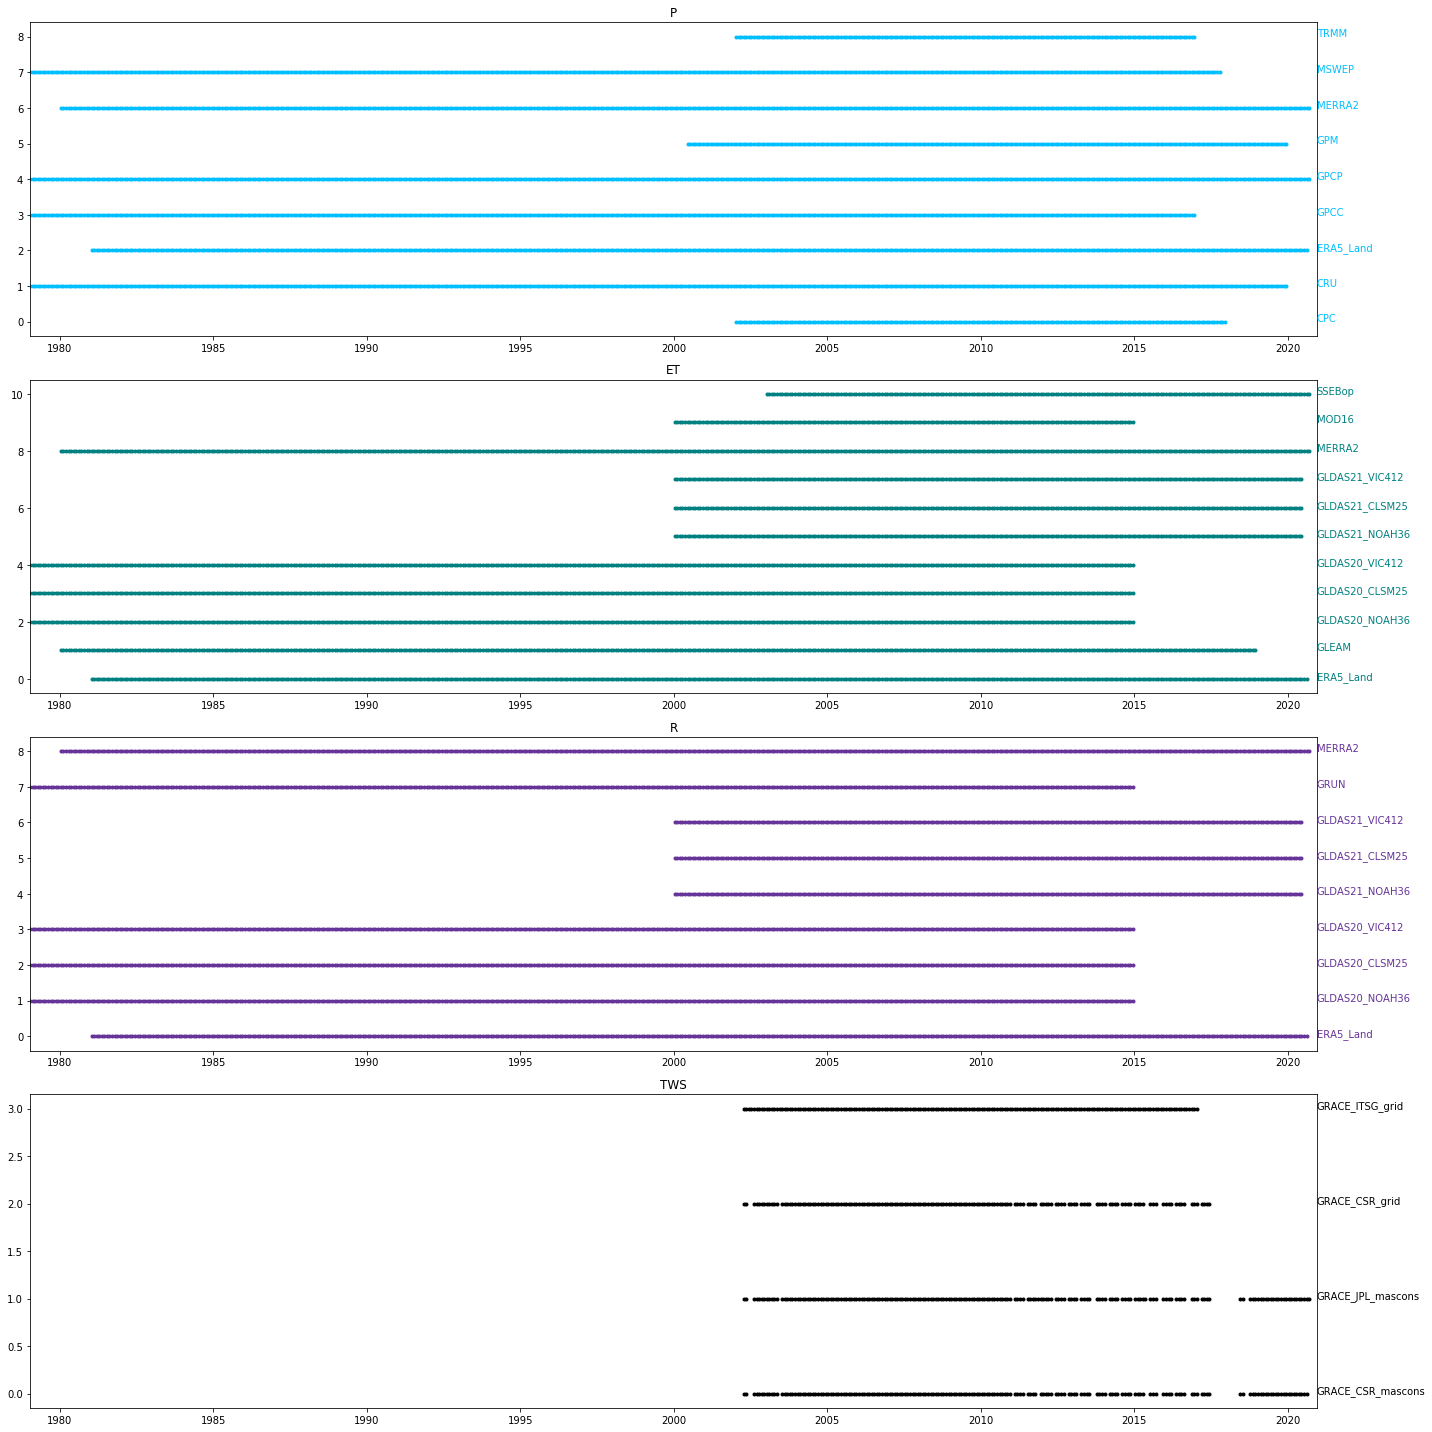

In [20]:
plt.figure(figsize=(20,20))

for nplot,hydro_var_name in enumerate(['P','ET','R','TWS']):
    plt.subplot(4,1,nplot+1)
    for i,data in enumerate(list_data[hydro_var_name]):
        if hydro_var_name=='TWS' and data!='GRACE_ITSG_grid':
            (spatial_grid,hydro_grid,time_hydro)=load_hydro_data(hydro_var_name,data,
                                    fill_value=dict_fill_value[data],version=version_data[data])
            to_plot=time_hydro.copy()
            to_plot[np.where(np.sum(np.isnan(hydro_grid.iloc[:,3:]))==spatial_grid.shape[0])[0]]=np.nan
        else:
            hydro_month=pd.read_csv('../results/hydrology/{}_{}_monthly.csv'.format(hydro_var_name,data),
                                                                index_col=[0])
            to_plot=pd.to_datetime(hydro_month.columns.str[len(hydro_var_name)+1+len(data):])
        plt.plot(to_plot,i*np.ones_like(to_plot,dtype=float),color=dict_color[hydro_var_name],marker='.',label=data)
        plt.text(date(2020,12,15),i,data,c=dict_color[hydro_var_name])
    plt.xlim([date(1979,1,15),date(2020,12,15)])
    plt.title(hydro_var_name)
plt.tight_layout()
plt.show()    